In [1]:
import os; import numpy as np
from pathlib import Path
from IPython import get_ipython
from dotenv import load_dotenv
from pathlib import Path

if get_ipython().execution_count == 1:
    parent_dir = Path.cwd().parent.resolve()
    os.chdir(parent_dir)

load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir():  # make sure it exists
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

In [2]:
from src.data.manager import *
from src.data.transform import *
from src.data.features import *
from src.data.strategy import *
from src.model import *
from src.universe import *

stocks = [
    #"AAPL", "MSFT", "NVDA", "GOOG", "GOOGL",
    #"AMZN", "META", "AVGO", "TSLA", "PEP",
    #"COST", "NFLX", "ADBE", "CSCO", "AMD",
    "INTC", "LIN", "TXN", "QCOM", "AMAT"
]
for stock in stocks.copy():
    if stock not in available_ticks:
        print(f"Removing {stock} from universe - data not available")
        stocks.remove(stock)
universe = Universe(stocks)
data_manager = DataManager(universe, load_lazy=True)

Transformer(data_manager)('scale_by_splits')
Transformer(data_manager)('to_datetime', columns=['trade_date', 'expiry_date'])
Transformer(data_manager)('drop_stale_options', volume_threshold=100)
Transformer(data_manager)('pull_earnings_dates')
Transformer(data_manager)('set_index', index_cols=['strike', 'trade_date', 'expiry_date', 'call_put'], dedupe=True)
Transformer(data_manager)('filter_ttms', min_ttm=3)
Transformer(data_manager)('compute_rv', period=30)
Transformer(data_manager)('train_test_split', test_size=0.35, drop_out_of_sample=True)
Transformer(data_manager)('implied_volatility')
Transformer(data_manager)('mid_price')

Features(data_manager)('iv_rv_ratio')
Features(data_manager)('term_structure_slope', near_expiry_days=14, far_expiry_days=30)
Features(data_manager)('mac_vol', lookback_short=5, lookback_long=30)
Features(data_manager)('days_to_earnings')
Features(data_manager)('days_since_earnings')
Strategy(data_manager)('earnings_calendar_spread',
                          entry_offset=1,
                          exit_offset=0,
                          ttm_short=10,
                          ttm_long=30,
                          call_delta=0.45,
                          put_delta=-0.45,
                          position=1)
Features(data_manager)('prepare_data')
MultiLayerPerceptron(data_manager)('fit_predict', y_col='combined_pnl', X_cols=['average_iv_ratio', 'average_slope', 'mac_volume'], all_stocks=True, diff_ticks='tick')
LinearRegression(data_manager)('fit_predict', y_col='combined_pnl', X_cols=['average_iv_ratio', 'average_slope', 'mac_volume'], all_stocks=True, diff_ticks='tick')
data_manager.execute_pipeline(retain_data=True, save_data=False)


Deferring method fit_predict for all stocksRunning post-processing method fit_predict for ticks ['INTC', 'LIN', 'TXN', 'QCOM', 'AMAT']
{'X_cols': ['average_iv_ratio', 'average_slope', 'mac_volume'], '_source': 'Model', 'all_stocks': True, 'diff_ticks': 'tick', 'y_col': 'combined_pnl'}
Running post-processing method fit_predict for ticks ['INTC', 'LIN', 'TXN', 'QCOM', 'AMAT']
{'X_cols': ['average_iv_ratio', 'average_slope', 'mac_volume'], '_source': 'Model', 'all_stocks': True, 'diff_ticks': 'tick', 'y_col': 'combined_pnl'}


KeyError: None

Text(0.5, 0, 'Predicted PnL')

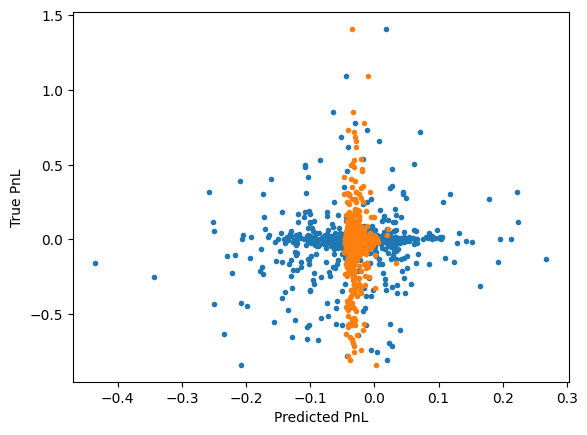

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data_manager.combined_outputs['fit_predict']['multi_layer_perceptron_prediction'],data_manager.combined_outputs['fit_predict']['combined_pnl'],  '.') 
plt.plot(data_manager.combined_outputs['fit_predict']['linear_regression_prediction'],data_manager.combined_outputs['fit_predict']['combined_pnl'],  '.') 
plt.ylabel('True PnL')
plt.xlabel('Predicted PnL')

In [ ]:
def earnings_calendar_spread(data, **kwargs):
        """Implements an earnings calendar spread strategy."""

        entry_offset = kwargs.get("entry_offset", 1)
        exit_offset = kwargs.get("exit_offset", 0)
        exit_tolerance = kwargs.get("exit_tolerance", 3)
        position = kwargs.get("position", 1)  
        call_delta = kwargs.get("delta", 0.5)
        put_delta = kwargs.get("put_delta", -0.5)
        ttm_short = kwargs.get("ttm_short", 14)
        ttm_long = kwargs.get("ttm_long", 30)

        filtered_df = data.copy()[(data['bdays_to_earnings'] <= entry_offset) | (data['bdays_since_earnings'] <= exit_offset)]
        dbf_mask = (filtered_df['bdays_to_earnings'] == entry_offset)
        after_mask = (filtered_df['bdays_since_earnings'] >= exit_offset  & (filtered_df['bdays_since_earnings'] < exit_offset + exit_tolerance))
        post_data = filtered_df[after_mask].copy()

        short_call = filtered_df[(dbf_mask) & (filtered_df['ttm'] <= ttm_short) & (filtered_df['delta'] >= call_delta) & (filtered_df['call_put'] == 'c')]
        short_put = filtered_df[(dbf_mask) & (filtered_df['ttm'] <= ttm_short) & (filtered_df['delta'] <= put_delta) & (filtered_df['call_put'] == 'p')]
        long_call = filtered_df[(dbf_mask) & (filtered_df['ttm'] >= ttm_long) & (filtered_df['delta'] >= call_delta) & (filtered_df['call_put'] == 'c')]
        long_put = filtered_df[(dbf_mask) & (filtered_df['ttm'] >= ttm_long) & (filtered_df['delta'] <= put_delta) & (filtered_df['call_put'] == 'p')]

        # Take nearest delta if multiple options meet criteria
        if not short_call.empty:
            short_call = short_call.loc[short_call.groupby('trade_date')['delta'].idxmin()]
        if not short_put.empty:
            short_put = short_put.loc[short_put.groupby('trade_date')['delta'].idxmin()]
        if not long_call.empty:
            long_call = long_call.loc[long_call.groupby('trade_date')['delta'].idxmin()]
        if not long_put.empty:
            long_put = long_put.loc[long_put.groupby('trade_date')['delta'].idxmin()]

        # Take max expiry for shorts and min expiry for longs to ensure proper calendar spread
        short_call = short_call.loc[short_call.groupby('trade_date')['expiry_date'].idxmax()]
        short_put = short_put.loc[short_put.groupby('trade_date')['expiry_date'].idxmax()]
        long_call = long_call.loc[long_call.groupby('trade_date')['expiry_date'].idxmin()]
        long_put = long_put.loc[long_put.groupby('trade_date')['expiry_date'].idxmin()]

        # Take exits as the smallest dtm within after_mask, subject to call_put, exdate and strike matching the entry
        # Add 'side' and preserve original index
        for df, side in zip([short_call, short_put, long_call, long_put], [-1, -1, 1, 1]):
            df['position'] = side * position
            df['data_index'] = df.index

        entries = pd.concat([short_call, short_put, long_call, long_put])

        # Use a Series instead of a list, keyed by the entries index
        exit_prices = pd.Series(index=entries.index, dtype=float)
        exit_date = pd.Series(index=entries.index, dtype=int)
        entry_prices = entries['mid_price'].copy()

        for idx, row in entries.iterrows():
            candidate_exits = post_data[
                (post_data['strike'] == row['strike']) &
                (post_data['expiry_date'] == row['expiry_date']) &
                (post_data['call_put'] == row['call_put'])
            ]
            if not candidate_exits.empty:
                exit_prices.loc[idx] = candidate_exits.loc[candidate_exits['ttm'].idxmin(), 'mid_price']
                exit_date.loc[idx] = candidate_exits.loc[candidate_exits['ttm'].idxmin()].name[1]  # trade_date index
            else:
                exit_prices.loc[idx] = np.nan

        entries['mid_price_exit'] = exit_prices
        entries['data_index_exit'] = exit_date
        entries['pnl'] = entries['position'] * (entries['mid_price_exit'] - entry_prices) / entry_prices

        results = entries.set_index('data_index')[['data_index_exit', 'position', 'mid_price', 'mid_price_exit', 'pnl']]
        results = results.reindex(data.index) 
        results = results.rename(columns={'mid_price': 'mid_price_entry', 'data_index_exit': 'trade_exit_date'}) 

        return results





_ = earnings_calendar_spread(data_manager.data['AAPL'])
_.dropna()

C:\Users\cameronA\AppData\Local\Temp\ipykernel_15224\3535394886.py:60: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2010-07-20 00:00:00-04:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  exit_date.loc[idx] = candidate_exits.loc[candidate_exits['ttm'].idxmin()].name[1]  # trade_date index


,,,,trade_exit_date,position,mid_price_entry,mid_price_exit,pnl
strike_idx,trade_date_idx,expiry_date_idx,call_put_idx,,,,,
9.285714,2010-04-16 00:00:00-04:00,2011-01-22 00:00:00-05:00,c,2011-01-18 00:00:00-05:00,1.0,0.846429,2.918750,2.448312
10.357143,2010-04-16 00:00:00-04:00,2010-05-22 00:00:00-04:00,p,2010-04-21 00:00:00-04:00,1.0,1.536607,1.107143,-0.279489
8.928571,2010-04-20 00:00:00-04:00,2010-10-16 00:00:00-04:00,c,2010-07-20 00:00:00-04:00,1.0,0.668750,0.728571,0.089453
10.357143,2010-04-20 00:00:00-04:00,2010-06-19 00:00:00-04:00,p,2010-04-21 00:00:00-04:00,1.0,1.657143,1.138393,-0.313039
9.285714,2010-07-19 00:00:00-04:00,2010-07-23 00:00:00-04:00,p,2010-07-20 00:00:00-04:00,-1.0,0.602679,0.408929,0.321481
...,...,...,...,...,...,...,...,...
66.250000,2019-10-29 00:00:00-04:00,2019-12-20 00:00:00-05:00,p,2019-10-29 00:00:00-04:00,1.0,5.918750,5.918750,0.000000
77.500000,2020-01-27 00:00:00-05:00,2020-02-07 00:00:00-05:00,c,2020-01-28 00:00:00-05:00,-1.0,2.487500,3.443750,-0.384422
95.000000,2020-01-27 00:00:00-05:00,2020-01-31 00:00:00-05:00,p,2020-01-27 00:00:00-05:00,-1.0,17.581250,17.581250,-0.000000


In [ ]:
data_manager.outputs['AAPL'].dropna()

,combined_pnl,average_iv_ratio,average_slope,average_volume,multi_layer_perceptron_prediction,linear_regression_prediction
trade_date_idx,,,,,,
2010-07-19 00:00:00-04:00,-2.675585e-02,1.961473,-0.010781,3414.525000,0.035701,-0.017345
2010-10-15 00:00:00-04:00,2.749703e-01,2.420112,-0.009016,4385.925000,0.049875,-0.021108
2011-07-18 00:00:00-04:00,-2.583026e-02,2.147022,-0.011620,5653.791667,0.029684,-0.013534
2011-10-17 00:00:00-04:00,-2.104208e-02,1.822901,-0.008206,3054.633333,0.128022,-0.024347
2012-01-23 00:00:00-05:00,-5.715105e-01,2.611595,-0.006386,918.141667,-0.051229,-0.030314
2012-04-23 00:00:00-04:00,-1.169809e-02,1.732182,-0.008166,1220.091667,0.053205,-0.025763
2012-07-23 00:00:00-04:00,-3.013179e-01,2.468953,-0.005285,2160.616667,-0.093766,-0.032358
2013-01-22 00:00:00-05:00,-9.731574e-02,1.524802,-0.006084,1034.416667,0.067384,-0.031381
2013-04-22 00:00:00-04:00,-4.259633e-01,1.845945,-0.004474,1339.983333,-0.207577,-0.035252
